# Notebook to run Facebook news experiment

### This notebook implements IGL-P(3) and evaluates its performance on a simulator using Facebook news data for three latent reward states

### Preprocessed data

For ease of experimentation, we include preprocessed data files with our code (action_set.csv). We use 3 files from the Martinchek dataset corresponding to all posts made by (1) Fox News, (2) The Huffington Post and (3) TIME Magazine. Each row of the original dataset included a post_id (this is preserved in our preprocessed data set), information about the type of post, date of post, text information, total number of interactions for (1) likes, (2) comments, (3) shares, (4) love, (5) wow, (6) haha, (7) sad and (8) angry.

For each data set we compute a correlation matrix and then use PCA to obtain a low dimensional representation of the structure between different signals. We use clustering on the results to determine how feedback signals are related and then assign the cluster containing the 'like' signal to correspond to r=1 signals, the cluster containing the angry signal to correspond to r=-1 and the remaining cluster contains signals that correspond to the r=0 state. For the probabilities of a user emitting a given signal while in a state, we use aggregate statistics for the given news source across 6 months of data. Finally, we introduce the 'none' signal for r=0 and assign it a probability of 0.9 to account for the fact that the vast majority of people do not interact with posts.

Using the embedding of signals, we compute a latent score for each post. We then look at all the posts from a given day and chose the post with the highest latent score as being the action with r=1. For the remaining actions we chose 14 actions with low engagement rates, implying that they have r!=1. Of the 14 chosen actions, we select the action with the lowest latent score as having r=-1. We do this for all days in the 6 month period from May to November 2016. This gives us 175 "action sets" that each consist of 15 actions, where 1 has reward r=1, 1 has reward r=-1 and 13 have reward r=0.

For the action features of the posts, we use the 'paraphrase-MiniLM-L6-v2' from SentenceTransformers to summarize the text content of the post, as well as information about the type of post (link, video, photo, status or event), encoded as a one-hot. The resulting action features are nearly 400 dimensional vectors, and all action features in the preprocessed data set were generated in the same way.

In [1]:
def from_np_array(array_string): # otherwise have issues reading in numpy arrays from pd csv
    import numpy as np
    import ast
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

def get_cooked_data(file_name):
    import pandas as pd
    data = pd.read_csv('action_sets.csv',index_col=0,
                   converters={'action_feat': from_np_array})
    return data

In [2]:
data = get_cooked_data('action_sets.csv')

## Accuracy helper function

In [3]:
import torch
import pandas as pd

class EasyAcc:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sumsq = 0

    def __iadd__(self, other):
        self.n += 1
        self.sum += other
        self.sumsq += other*other
        return self

    def __isub__(self, other):
        self.n += 1
        self.sum -= other
        self.sumsq += other*other
        return self

    def mean(self):
        return self.sum / max(self.n, 1)

    def var(self):
        from math import sqrt
        return sqrt(self.sumsq / max(self.n, 1) - self.mean()**2)

    def semean(self):
        from math import sqrt
        return self.var() / sqrt(max(self.n, 1))

class IK(torch.nn.Module):
    def __init__(self, dim_x, dim_a, dim_y):
        super().__init__()
        self.bilinear = torch.nn.Bilinear(in1_features=dim_x*dim_a, in2_features=dim_y, out_features=1)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    # Xs --> [batch, dim_x] 
    # As --> [batch, num_a, dim_a] 
    # Ys --> [batch, dim_y]
    def prelogits(self, Xs, As, Ys):
        batch, numa, dima = As.shape
        _, dimx = Xs.shape
        
        xview = Xs.unsqueeze(1).unsqueeze(3)            # [ batch, 1, dim_x, 1 ]
        aview = As.unsqueeze(2)                         # [ batch, num_a, 1, dim_a ]
        xaouter = torch.matmul(xview, aview)            # [ batch, num_a, dim_x, dim_a ]
        yview = Ys.unsqueeze(1).expand(-1, numa, -1)    # [ batch, num_a, dim_y ]
        return self.bilinear(xaouter.view(-1, numa, dimx*dima), yview).view(-1, numa)
    
    def predictions(self, prelogits):
        return self.softmax(prelogits)

class BilinearPredictor(torch.nn.Module):
    def __init__(self, dim_x, dim_a):
        super().__init__()
        if dim_x * dim_a > 0:
            self.bilinear = torch.nn.Bilinear(in1_features=dim_x, in2_features=dim_a, out_features=1)
        else:
            self.bilinear = None
            self.b = torch.nn.Parameter(torch.zeros(1))
        self.sigmoid = torch.nn.Sigmoid()
        
    def prelogits(self, Xs, As):
        if self.bilinear is not None:
            return self.bilinear(Xs, As).squeeze(1)
        else:
            return self.b.expand(Xs.shape[0])
    
    def prediction(self, prelogits):
        return self.sigmoid(prelogits)

class Policy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def sample(self, Fs):
        raise NotImplementedError
        
    def update(self, dt):
        raise NotImplementedError
        
class EpsilonGreedy(Policy):
    def __init__(self, epsilon, epsilon_t0):
        super().__init__()
        self.epsilon = epsilon
        self.epsilon_t0 = epsilon_t0
        self.t = epsilon_t0
        
    def myeps(self):
        return self.epsilon * (self.epsilon_t0 / self.t)**(1/3)
        
    def sample(self, Fs, As):
        myeps = self.myeps()
        
        unif = torch.rand(size=(Fs.shape[0], 1))
        should_explore = (unif < myeps).long()
        
        explore = torch.randint(low=0, high=Fs.shape[1], size=(Fs.shape[0], 1))
        exploit = torch.max(Fs, dim=1, keepdim=True).indices
        
        aindex = exploit + should_explore * (explore - exploit)
        action = torch.gather(input=As, dim=1, index=aindex.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
        
        isgreedy = (aindex == exploit).long()
        
        paction = myeps * torch.ones(size=(Fs.shape[0],1))/Fs.shape[1] + isgreedy * (1 - myeps)
        return action, paction, aindex
    
    def update(self, dt):
        self.t += dt

In [4]:
class NuThreeStateSimulator(torch.utils.data.Dataset):
    def __init__(self, *, T, data, seed):
        import random
        import pandas as pd
        
        super().__init__()

        self.data = data
        self.random = random.Random(seed)
        self.nusers = len(pd.unique(data['news_id']))
        self.nactionsets = len(pd.unique(data['set_id']))
        self.actdim = len(data['action_feat'].iloc[0])
        self.nactions = 15
        self.probs = {'fox':{0:[0.9,0,0,0,0,0,0,0.1,0],
                             1:[0,0.744328,0,0.238383,0.017289,0,0,0,0],
                             -1:[0,0,0.826858,0,0,0.023984,0.040857,0,0.108301]},
                      'huffpost':{0:[0.9,0,0.016804,0.080953,0,0,0.002243,0,0],
                                  1:[0,0.977411,0,0,0.022589,0,0,0,0],
                                  -1:[0,0,0,0,0,0.236086,0,0.347774,0.416139]},
                      'time':{0:[0.9,0,0,0,0,0.038336,0.061664,0,0],
                              1:[0,0.723603,0.060473,0.186107,0.029816,0,0,0,0],
                              -1:[0,0,0,0,0,0,0,0.633414,0.366586]}}
    
        self.feedbacks = ['none','like','comment','share','love','wow','haha','sad','angry']
        self.cmap = {0:'fox',1:'huffpost',2:'time'}
        
        self.contexts = torch.Tensor([ self.random.randint(0, self.nusers-1) for _ in range(T) ]).long()
        self.actionsets = torch.Tensor([ self.random.randint(0, self.nactionsets-1) for _ in range(T) ]).long()
        self.random = random.Random(1664525*seed + 1013904223)

    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        context = torch.nn.functional.one_hot(self.contexts[idx], num_classes=self.nusers).float()
        data_set = self.data[(self.data['news_id']==self.cmap[self.contexts[idx].item()])& (self.data['set_id']==self.actionsets[idx].item())]
        action_set = data_set['action_feat']
        action_set.reset_index(drop=True, inplace=True)
        actions = torch.zeros(self.nactions,self.actdim)
        for count, value in enumerate(action_set):
            actions[count,:] = torch.Tensor(value).float()
        return context, actions

    def first_nonzero(self, x, axis=0):
        nonz = (x != 0)
        return ((nonz.cumsum(axis) == 1) & nonz).max(axis, keepdim=True)
    
    def get_one_hot_id(self, onehot):
        return self.first_nonzero(onehot, axis=-1)[1].squeeze().item()
    
    def sample_feedback(self, Xs, Rs):
        results = []
        for context, reward in zip(Xs, Rs):
            probs = self.probs[self.cmap[self.get_one_hot_id(context)]][reward.item()]
        
            feedback = self.random.choices(list(range(len(self.feedbacks))), weights=probs)[0]

            results.append(torch.nn.functional.one_hot(torch.LongTensor([feedback]), num_classes = len(self.feedbacks)).float())
        return torch.cat(results, dim=0)
    
    def is_definitely_negative(self, Xs, Ys):
        return self.first_nonzero(Ys, axis=-1)[1].squeeze(1) == 8

    def trueReward(self, Xs, Ainds):
        reward_all = torch.Tensor([ (aind.item() == 0)-(aind.item() == self.nactions-1)for aind in Ainds ])
        reward_fox = []
        reward_huffpost = []
        reward_time = []
        for x, aind in zip(Xs,Ainds):
            if self.get_one_hot_id(x) == 0:
                reward_fox.append((aind.item() == 0)-(aind.item()== self.nactions-1))
            elif self.get_one_hot_id(x) == 1:
                reward_huffpost.append((aind.item() == 0)-(aind.item()== self.nactions-1))
            else:
                reward_time.append((aind.item() == 0)-(aind.item()== self.nactions-1))            
        return reward_all, reward_fox, reward_huffpost, reward_time

# Epsilon-Greedy

In [5]:
def noglobalz_iglp3(*, seed, T, data):
    from math import sqrt
    import itertools
    
    nusers = len(pd.unique(data['news_id']))
    nactions = len(data['action_feat'].iloc[0])
    numr = 3
    batch_size = 100
    lr = 0.001
    epsilon = 1
    epsilon_t0 = 100
     
    true_rewards = []
    positive_rewards_counter = []
    negative_rewards_counter = []
    neutral_rewards_counter = []
    
    true_rewards_fox = []
    true_rewards_huffpost = []
    true_rewards_time = []

    sim = NuThreeStateSimulator(T=T,data=data,seed=seed); seed += 1
    
    torch.manual_seed(seed); seed += 1
    loader = torch.utils.data.DataLoader(sim, batch_size=batch_size, shuffle=False)

    policy = EpsilonGreedy(epsilon, epsilon_t0)

    ik = IK(dim_x=nusers, dim_a=nactions, dim_y=len(sim.feedbacks))
    negpredictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)
    constpredictor = BilinearPredictor(dim_x=0, dim_a=0)
    rewardpredictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)

    actionloss = torch.nn.CrossEntropyLoss(reduction='none')
    actionoptimizer = torch.optim.Adam(ik.parameters(), lr=lr*sqrt(batch_size))
    negloss = torch.nn.BCEWithLogitsLoss(reduction='none')
    negoptimizer = torch.optim.Adam(itertools.chain(negpredictor.parameters(), constpredictor.parameters()), lr=lr*sqrt(batch_size))
    regloss = torch.nn.MSELoss(reduction='none')
    regoptimizer = torch.optim.Adam(rewardpredictor.parameters(), lr=lr*sqrt(batch_size))

    print('{:<5s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s}'.format(
        'bno',  'loss', 'since', 'acc', 'since', 'neg', 'since', 'const', 'since', 'reg', 'since', 'pol', 'since', 'greedy', 'since', 'eps'), flush=True) 
    avloss, avacc, avnegloss, avconstloss, avregloss, avpol, avgreedy = [ EasyAcc() for _ in range(7) ]
    avlosssincelast, avaccsincelast, avneglosssincelast, avconstlosssincelast, avreglosssincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(7) ]
    
    for bno, minibatch in enumerate(loader):
        Xs, As = minibatch

        with torch.no_grad():
            rhat = rewardpredictor.prelogits(Xs.unsqueeze(1).expand(-1, As.shape[1], -1), As).squeeze(2)
            action, paction, aindex = policy.sample(rhat, As)
            truerewards, foxrewards, huffpostrewards, timerewards = sim.trueReward(Xs,aindex)
            avpol += torch.mean(truerewards).item()
            avpolsincelast += torch.mean(truerewards).item()
            
            true_rewards_fox.append(foxrewards)
            true_rewards_huffpost.append(huffpostrewards)
            true_rewards_time.append(timerewards)
            
            true_rewards.append(torch.mean(truerewards).item())

            greedy = torch.max(rhat, dim=1, keepdim=True).indices
            greedyaction = torch.gather(input=As, dim=1, index=greedy.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
            greedyrewards,_,_,_ = sim.trueReward(Xs,greedy)
            avgreedy += torch.mean(greedyrewards).item()
            avgreedysincelast += torch.mean(greedyrewards).item()

            Ys = sim.sample_feedback(Xs, truerewards)
            
        actionoptimizer.zero_grad()
        prepapred = ik.prelogits(Xs, As, Ys)
        
        rawactionloss = actionloss(prepapred, aindex.squeeze(1)).unsqueeze(1)
        actioniw = 1/(As.shape[1]*paction)
        batchactionloss = torch.sum(torch.mul(actioniw, rawactionloss)) / torch.sum(actioniw)
        batchactionloss.backward() #learn
        actionoptimizer.step()
                
        with torch.no_grad():
            papred = torch.gather(input=ik.predictions(prepapred), index=aindex, dim=1).squeeze()
            
            isExtreme = papred > (2 / As.shape[1])
            
        if torch.any(isExtreme):
            extremeXs = torch.atleast_2d(Xs[isExtreme])
            extremeAs = torch.atleast_2d(action[isExtreme])
            extremeYs = torch.atleast_2d(Ys[isExtreme])
            extremepaction = torch.atleast_2d(paction[isExtreme])
            with torch.no_grad():
                isNeg = sim.is_definitely_negative(extremeXs, extremeYs).float()
                
            negoptimizer.zero_grad()
            negpred = negpredictor.prelogits(extremeXs, extremeAs)
            constpred = constpredictor.prelogits(torch.empty(extremeXs.shape[0], 0), None)
            extremeactioniw = 1/(As.shape[1]*extremepaction)
            batchnegloss = torch.sum(torch.mul(extremeactioniw, negloss(negpred, isNeg).unsqueeze(1))) / torch.sum(extremeactioniw)
            batchconstloss = torch.sum(torch.mul(extremeactioniw, negloss(constpred, isNeg).unsqueeze(1))) / torch.sum(extremeactioniw)
            (batchnegloss + batchconstloss).backward()
            negoptimizer.step()
            
            with torch.no_grad():
                fakereward = torch.zeros(Xs.shape[0])
                fakereward[isExtreme] = 1 - 2 * (negpred > constpred).float()

                states, counts = fakereward.unique(return_counts=True)
                
                if -1 not in states:
                    negative_rewards_counter.append(0)
                
                if 1 not in states:
                    positive_rewards_counter.append(0)
    
                for latent_reward, count in zip(states, counts):
                    if latent_reward.item() == -1:
                        negative_rewards_counter.append(count.item())
                    elif latent_reward.item() == 1:
                        positive_rewards_counter.append(count.item())
                    else:
                        neutral_rewards_counter.append(count.item())
            
            regoptimizer.zero_grad()
            rewardpred = rewardpredictor.prelogits(Xs, action)
            batchregloss = torch.sum(torch.mul(actioniw, regloss(rewardpred, fakereward).unsqueeze(1))) / torch.sum(actioniw)
            batchregloss.backward()
            regoptimizer.step()
            
            with torch.no_grad():
                policy.update(Xs.shape[0])
        else:
            batchnegloss = None

        with torch.no_grad():
            avloss += batchactionloss.item()
            avlosssincelast += batchactionloss.item()
            if batchnegloss is not None:
                avnegloss += batchnegloss.item()
                avneglosssincelast += batchnegloss.item()
                avconstloss += batchconstloss.item()
                avconstlosssincelast += batchconstloss.item()
                avregloss += batchregloss.item()
                avreglosssincelast += batchregloss.item()
                
            amaxpred = torch.max(prepapred, dim=1, keepdim=True)
            avacc += torch.mean(torch.mul(actioniw, (aindex == amaxpred.indices).float())).item()
            avaccsincelast += torch.mean(torch.mul(actioniw, (aindex == amaxpred.indices).float())).item()

            if bno & (bno - 1) == 0:
                print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
                    bno,  
                    avloss.mean(), avlosssincelast.mean(),
                    avacc.mean(), avaccsincelast.mean(),
                    avnegloss.mean(), avneglosssincelast.mean(),
                    avconstloss.mean(), avconstlosssincelast.mean(),
                    avregloss.mean(), avreglosssincelast.mean(),
                    avpol.mean(), avpolsincelast.mean(),
                    avgreedy.mean(), avgreedysincelast.mean(),
                    policy.myeps(),
                ), 
                      flush=True)
                avlosssincelast, avaccsincelast, avneglosssincelast, avconstlosssincelast, avreglosssincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(7) ]

    print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
        bno,  
        avloss.mean(), avlosssincelast.mean(),
        avacc.mean(), avaccsincelast.mean(),
        avnegloss.mean(), avneglosssincelast.mean(),
        avconstloss.mean(), avconstlosssincelast.mean(),
        avregloss.mean(), avreglosssincelast.mean(),
        avpol.mean(), avpolsincelast.mean(),
        avgreedy.mean(), avgreedysincelast.mean(),
        policy.myeps()
    ), flush=True)
    
    return true_rewards, positive_rewards_counter, negative_rewards_counter, neutral_rewards_counter, true_rewards_fox, true_rewards_huffpost, true_rewards_time

In [6]:
def noglobalz_cb(*, seed, T, data, cb_reward_mapping):
    from math import sqrt
    import itertools
    
    
    nusers = len(pd.unique(data['news_id']))
    nactions = len(data['action_feat'].iloc[0])
    numr = 3
    batch_size = 100
    lr = 0.001
    epsilon = 1
    epsilon_t0 = 100
        
    true_rewards = []
    
    true_rewards_fox = []
    true_rewards_huffpost = []
    true_rewards_time = []
    
    positive_rewards_counter = []
    negative_rewards_counter = []
    neutral_rewards_counter = []

    sim = NuThreeStateSimulator(T=T,data=data,seed=seed); seed += 1
    
    torch.manual_seed(seed); seed += 1
    loader = torch.utils.data.DataLoader(sim, batch_size=batch_size, shuffle=False)

    policy = EpsilonGreedy(epsilon, epsilon_t0)

    ik = IK(dim_x=nusers, dim_a=nactions, dim_y=len(sim.feedbacks))
    negpredictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)
    constpredictor = BilinearPredictor(dim_x=0, dim_a=0)
    rewardpredictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)

    actionloss = torch.nn.CrossEntropyLoss(reduction='none')
    actionoptimizer = torch.optim.Adam(ik.parameters(), lr=lr*sqrt(batch_size))
    negloss = torch.nn.BCEWithLogitsLoss(reduction='none')
    negoptimizer = torch.optim.Adam(itertools.chain(negpredictor.parameters(), constpredictor.parameters()), lr=lr*sqrt(batch_size))
    regloss = torch.nn.BCEWithLogitsLoss(reduction='none')
    regoptimizer = torch.optim.Adam(rewardpredictor.parameters(), lr=lr*sqrt(batch_size))

    print('{:<5s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s}'.format(
        'bno',  'loss', 'since', 'acc', 'since', 'neg', 'since', 'const', 'since', 'reg', 'since', 'pol', 'since', 'greedy', 'since', 'eps'), flush=True) 
    avloss, avacc, avnegloss, avconstloss, avregloss, avpol, avgreedy = [ EasyAcc() for _ in range(7) ]
    avlosssincelast, avaccsincelast, avneglosssincelast, avconstlosssincelast, avreglosssincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(7) ]
    
    for bno, minibatch in enumerate(loader):
        Xs, As = minibatch

        with torch.no_grad():
            rhat = rewardpredictor.prelogits(Xs.unsqueeze(1).expand(-1, As.shape[1], -1), As).squeeze(2)
            action, paction, aindex = policy.sample(rhat, As)
            truerewards, foxrewards, huffpostrewards, timerewards = sim.trueReward(Xs,aindex)
            avpol += torch.mean(truerewards).item()
            avpolsincelast += torch.mean(truerewards).item()
            
            true_rewards_fox.append(foxrewards)
            true_rewards_huffpost.append(huffpostrewards)
            true_rewards_time.append(timerewards)
            
            true_rewards.append(torch.mean(truerewards).item())

            greedy = torch.max(rhat, dim=1, keepdim=True).indices
            greedyaction = torch.gather(input=As, dim=1, index=greedy.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
            greedyrewards,_,_,_ = sim.trueReward(Xs,greedy)
            avgreedy += torch.mean(greedyrewards).item()
            avgreedysincelast += torch.mean(greedyrewards).item()

            Ys = sim.sample_feedback(Xs, truerewards)
            
            # fakereward based on the feedback type
            fakereward = torch.zeros(Xs.shape[0])
            for jj in range(len(sim.feedbacks)):
                fakereward += cb_reward_mapping[sim.feedbacks[jj]]*torch.Tensor(Ys[:,jj])

            states, counts = greedyrewards.unique(return_counts=True)
            
            if -1 not in states:
                negative_rewards_counter.append(0)
            
            if 1 not in states:
                positive_rewards_counter.append(0)

            for latent_reward, count in zip(states, counts):
                if latent_reward.item() == -1:
                    negative_rewards_counter.append(count.item())
                elif latent_reward.item() == 1:
                    positive_rewards_counter.append(count.item())
                else:
                    neutral_rewards_counter.append(count.item())
            
        regoptimizer.zero_grad()
        actioniw = 1/(As.shape[1]*paction)
        rewardpred = rewardpredictor.prelogits(Xs, action)
        batchregloss = torch.sum(torch.mul(actioniw, regloss(rewardpred, fakereward).unsqueeze(1))) / torch.sum(actioniw)
        batchregloss.backward()
        regoptimizer.step()
        
        with torch.no_grad():
            policy.update(Xs.shape[0])

        with torch.no_grad():

            if bno & (bno - 1) == 0:
                print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
                    bno,  
                    avloss.mean(), avlosssincelast.mean(),
                    avacc.mean(), avaccsincelast.mean(),
                    avnegloss.mean(), avneglosssincelast.mean(),
                    avconstloss.mean(), avconstlosssincelast.mean(),
                    avregloss.mean(), avreglosssincelast.mean(),
                    avpol.mean(), avpolsincelast.mean(),
                    avgreedy.mean(), avgreedysincelast.mean(),
                    policy.myeps(),
                ), 
                      flush=True)
                avlosssincelast, avaccsincelast, avneglosssincelast, avconstlosssincelast, avreglosssincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(7) ]

    print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
        bno,  
        avloss.mean(), avlosssincelast.mean(),
        avacc.mean(), avaccsincelast.mean(),
        avnegloss.mean(), avneglosssincelast.mean(),
        avconstloss.mean(), avconstlosssincelast.mean(),
        avregloss.mean(), avreglosssincelast.mean(),
        avpol.mean(), avpolsincelast.mean(),
        avgreedy.mean(), avgreedysincelast.mean(),
        policy.myeps()
    ), flush=True)
    
    return true_rewards, positive_rewards_counter, negative_rewards_counter, neutral_rewards_counter, true_rewards_fox, true_rewards_huffpost, true_rewards_time

In [7]:
def separate_rewards(rewards):
    neut, pos, neg = [], [], []

    for item in rewards:
        neut.append(sum([i==0 for i in item])/len(item))
        pos.append(sum([i==1 for i in item])/len(item))
        neg.append(sum([i==-1 for i in item])/len(item))
    
    return neut, pos, neg
    

def run_experiment(*, seed, T, data, cb_reward_mapping_1, cb_reward_mapping_2):
    _, _, _, _, igl_fox, igl_hp, igl_time = noglobalz_iglp3(seed=seed, T=T, data=data)
    _, _, _, _, cb1_fox, cb1_hp, cb1_time = noglobalz_cb(seed=seed, T=T, data=data, cb_reward_mapping = cb_reward_mapping_1)
    _, _, _, _, cb2_fox, cb2_hp, cb2_time = noglobalz_cb(seed=seed, T=T, data=data, cb_reward_mapping = cb_reward_mapping_2)

    return igl_fox, igl_hp, igl_time, cb1_fox, cb1_hp, cb1_time, cb2_fox, cb2_hp, cb2_time

def gen_plots(igl_fox, igl_hp, igl_time, cb1_fox, cb1_hp, cb1_time, cb2_fox, cb2_hp, cb2_time):
    from matplotlib import pyplot as plt
    from scipy.stats import sem
    
    import numpy as np

    r1_color = (120/255, 94/255, 240/255)
    r_1_color = (220/255, 38/255, 127/255)
    r0_color = (255/255, 176/255, 0/255)
    
    _, igl_f_p, igl_f_n = separate_rewards(igl_fox)
    _, igl_h_p, igl_h_n = separate_rewards(igl_hp)
    _, igl_t_p, igl_t_n = separate_rewards(igl_time)
    
    _, cb1_f_p, cb1_f_n = separate_rewards(cb1_fox)
    _, cb1_h_p, cb1_h_n = separate_rewards(cb1_hp)
    _, cb1_t_p, cb1_t_n = separate_rewards(cb1_time)
    
    _, cb2_f_p, cb2_f_n = separate_rewards(cb2_fox)
    _, cb2_h_p, cb2_h_n = separate_rewards(cb2_hp)
    _, cb2_t_p, cb2_t_n = separate_rewards(cb2_time)
    
    
    igl_means_p = [np.mean(igl_f_p),np.mean(igl_h_p),np.mean(igl_t_p)]
    igl_err_p = [sem(igl_f_p),sem(igl_h_p),sem(igl_t_p)]
    print('sem of averages for igl positive reward are'+str(igl_err_p))
    cb1_means_p = [np.mean(cb1_f_p),np.mean(cb1_h_p),np.mean(cb1_t_p)]
    cb1_err_p = [sem(cb1_f_p),sem(cb1_h_p),sem(cb1_t_p)]
    print('sem of averages for cb1 positive reward are'+str(cb1_err_p))
    cb2_means_p = [np.mean(cb2_f_p),np.mean(cb2_h_p),np.mean(cb2_t_p)]
    cb2_err_p = [sem(cb2_f_p),sem(cb2_h_p),sem(cb2_t_p)]
    print('sem of averages for cb2 positive reward are'+str(cb2_err_p))
    
    igl_means_n = [np.mean(igl_f_n),np.mean(igl_h_n),np.mean(igl_t_n)]
    igl_err_n = [sem(igl_f_n),sem(igl_h_n),sem(igl_t_n)]
    print('sem of averages for igl negative reward are'+str(igl_err_n))
    cb1_means_n = [np.mean(cb1_f_n),np.mean(cb1_h_n),np.mean(cb1_t_n)]
    cb1_err_n = [sem(cb1_f_n),sem(cb1_h_n),sem(cb1_t_n)]
    print('sem of averages for cb1 negative reward are'+str(cb1_err_n))
    cb2_means_n = [np.mean(cb2_f_n),np.mean(cb2_h_n),np.mean(cb2_t_n)]
    cb2_err_n = [sem(cb2_f_n),sem(cb2_h_n),sem(cb2_t_n)]
    print('sem of averages for cb2 positive reward are'+str(cb2_err_n))
    
    N = 3
    ind_x = np.arange(N) 
    width = 0.25

    plt.figure(figsize=(6, 3.5))
    plt.rcParams.update({'font.size': 14})
    bar1 = plt.bar(ind_x, igl_means_p, width, color = r1_color, label='IGL-P(3)')
    bar2 = plt.bar(ind_x+width, cb1_means_p, width, color=r0_color, label='CB-emoji')
    bar3 = plt.bar(ind_x+width*2, cb2_means_p, width, color = r_1_color, label='CB-comment')
    plt.ylabel('positive rewards')
    plt.xticks(ind_x+width,['Fox News', 'The Huffington Post', 'TIME'])
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),loc="lower left",ncol=3,prop={'size': 11.5})
    
    plt.figure(figsize=(6, 3.5))
    plt.rcParams.update({'font.size': 14})
    bar1 = plt.bar(ind_x, igl_means_n, width, color = r1_color, label='IGL-P(3)')
    bar2 = plt.bar(ind_x+width, cb1_means_n, width, color=r0_color, label='CB-emoji')
    bar3 = plt.bar(ind_x+width*2, cb2_means_n, width, color = r_1_color, label='CB-comment')
    plt.ylabel('negative rewards')
    plt.xticks(ind_x+width,['Fox News', 'The Huffington Post', 'TIME'])
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),loc="lower left",ncol=3,prop={'size': 11.5})

In [8]:
data_some = data[data['set_id']<22] # subsample set of all possible action sets to reduce training time

cb_rm1 =  {'none': 0, 'like':0.2, 'comment':0, 'share':0, 'love': 1 ,'wow':1 ,'haha':1, 'sad':1, 'angry':1} 
cb_rm2 =  {'none': 0, 'like':0, 'comment':1, 'share':0, 'love':0 ,'wow':0 ,'haha':0, 'sad':0, 'angry':0} 

igl_fox, igl_hp, igl_time, cb1_fox, cb1_hp, cb1_time, cb2_fox, cb2_hp, cb2_time = run_experiment(seed=31, T=200_000, data=data_some, cb_reward_mapping_1=cb_rm1, cb_reward_mapping_2=cb_rm2)

bno  	loss     since   	acc      since   	neg      since   	const    since   	reg      since   	pol      since   	greedy   since   	eps     
0    	2.72008  2.72008 	0.05000  0.05000 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	0.01000  0.01000 	-0.01000 -0.01000	1.00000 
1    	2.69531  2.67053 	0.06500  0.08000 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	-0.04000 -0.09000	-0.03000 -0.05000	1.00000 
2    	2.69906  2.70658 	0.06667  0.07000 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	-0.03667 -0.03000	-0.02667 -0.02000	1.00000 
4    	2.70011  2.70168 	0.07969  0.09923 	0.65186  0.65186 	0.69065  0.69065 	3.12523  3.12523 	-0.03400 -0.03000	-0.01200 0.01000 	0.69336 
8    	2.70158  2.70341 	0.08427  0.08998 	0.88543  1.00222 	0.68376  0.68032 	2.81409  2.65853 	-0.01778 0.00250 	-0.01556 -0.02000	0.52276 
16   	2.66601  2.62599 	0.10472  0.12774 	0.70911  0.57686 	0.66758  0.65544 	2.24059  1.81047 	-0.02118 -0.02500	-0.02529 -0.03625	0.40548 
32   	2.61715

sem of averages for igl positive reward are[0.0030042166790878607, 0.003506949686628027, 0.0031863003772975825]
sem of averages for cb1 positive reward are[0.0014243262627260877, 0.0004655334243035469, 0.000415943837769066]
sem of averages for cb2 positive reward are[0.000642949971692472, 0.0010457488586185608, 0.004112688050288712]
sem of averages for igl negative reward are[0.0027077535837508066, 0.0016039471780844678, 0.0014159489920677578]
sem of averages for cb1 negative reward are[0.0025078019142782265, 0.0032612020041720424, 0.0029660489783103587]
sem of averages for cb2 positive reward are[0.004174710238312498, 0.0013101985314351052, 0.0011071811294002317]


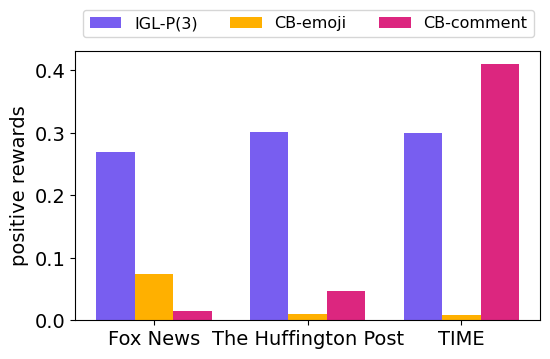

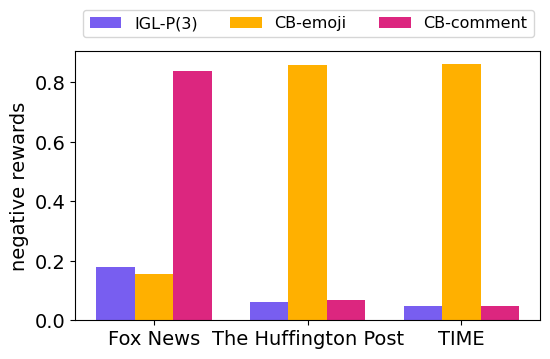

In [9]:
gen_plots(igl_fox, igl_hp, igl_time, cb1_fox, cb1_hp, cb1_time, cb2_fox, cb2_hp, cb2_time)